In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
#from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_gan as tfgan


2024-12-09 20:12:34.556422: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 20:12:34.600308: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 20:12:34.600340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 20:12:34.601659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 20:12:34.609128: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU name: NVIDIA A100-PCIE-40GB 



# Load MNIST dataset


In [3]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

In [4]:
from collections import defaultdict
from torch.utils.data import Subset
import numpy as np

# Group indices of each digit in the training dataset
digit_indices = defaultdict(list)
for idx, (image, label) in enumerate(training_dataset):
    digit_indices[label].append(idx)

# Stratify split by digits
train_indices = []
val_indices = []

for digit, indices in digit_indices.items():
    np.random.shuffle(indices)  # Shuffle indices for each digit
    split = int(0.8 * len(indices))  # 80% training, 20% validation
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

# Create Subset datasets for training and validation
train_dataset = Subset(training_dataset, train_indices)
val_dataset = Subset(training_dataset, val_indices)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Optional: Verify the distribution of digits
train_digit_counts = defaultdict(int)
val_digit_counts = defaultdict(int)

for _, label in train_dataset:
    train_digit_counts[label] += 1

for _, label in val_dataset:
    val_digit_counts[label] += 1

print("Training digit distribution:", dict(train_digit_counts))
print("Validation digit distribution:", dict(val_digit_counts))

Training set size: 47995
Validation set size: 12005
Training digit distribution: {5: 4336, 0: 4738, 4: 4673, 1: 5393, 9: 4759, 2: 4766, 3: 4904, 6: 4734, 7: 5012, 8: 4680}
Validation digit distribution: {5: 1085, 0: 1185, 4: 1169, 1: 1349, 9: 1190, 2: 1192, 3: 1227, 6: 1184, 7: 1253, 8: 1171}


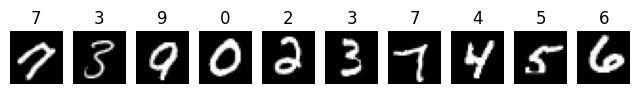

In [5]:
# show 10 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

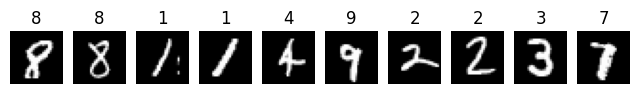

In [6]:
# show 10 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

# Define dataloaders


In [7]:
training_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True) # train_dataset is the split training dataset
validation_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# Linear_Variance_Scheduler


In [8]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start=0.0001, beta_end=0.02, device='cuda'):
        
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

# Cosine_Variance_Scheduler

In [9]:
class Cosine_Variance_Scheduler:
    def __init__(self, time_steps, s=0.008, start=0, end=1, tau=1, clip_min=1e-9, device='cuda'):
        self.time_steps = time_steps
        self.device = device

        # Generate alpha_bar values using cosine_schedule function
        self.alpha_bar = [self.cosine_schedule(t, time_steps, s) for t in range(time_steps)]
        self.alpha_bar = torch.tensor(self.alpha_bar, dtype=torch.float32).to(self.device)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

        # Generate betas
        self.betas_minus_0 = 1 - (self.alpha_bar[1:] / self.alpha_bar[:-1])
        self.beta_0 = torch.tensor(1 - math.cos(s * (math.pi / 2) / (1 + s)) ** 2, dtype=torch.float32)
        self.beta_0 = self.beta_0.unsqueeze(0)  # Convert to shape (1,)
        self.betas = torch.cat([self.beta_0.to(self.device), self.betas_minus_0])  # Add beta_0
        self.alphas = 1 - self.betas

    def cosine_schedule(self, t, T, s):
        f_t = math.cos((t / T + s) * (math.pi / 2) / (1 + s)) ** 2
        f_0 = math.cos(s * (math.pi / 2) / (1 + s)) ** 2
        alpha_bar_t = f_t / f_0
        return alpha_bar_t

    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    # Reverse process
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                
                # Generate noise
                if i > 1:
                    noise_scale = i / self.time_steps  # Gradually reduce noise
                    noise = noise_scale * torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                # Update x
                if i == 0:
                    x = x / torch.sqrt(alphas)  # Handle last step
                else:
                    x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) + \
                        torch.sqrt(betas) * noise

                if (i + 1) % 100 == 0 or i == 0:
                    collect.append(x.clone())  # Use clone to avoid modifying collected tensors
        return x, collect

# Sigmoid_Variance_Scheduler

In [10]:
class Sigmoid_Variance_Scheduler:
    def __init__(self, time_steps, k=10, t_0=0.5, device='cuda'):
        self.time_steps = time_steps
        self.device = device
        self.k = k
        self.t_0 = t_0

        steps = torch.linspace(0, 1, self.time_steps + 1, dtype=torch.float64)  # Normalized time steps from 0 to 1
        t = steps

        # Compute alpha_bar using the sigmoid function
        sigmoid = lambda t: 1 / (1 + torch.exp(-self.k * (t - self.t_0)))
        alpha_bar_t = 1 - sigmoid(t)  # Invert sigmoid to start from near 1 and decrease to near 0

        # Normalize alpha_bar_t to ensure it starts at 1 and ends near 0
        alpha_bar_t = (alpha_bar_t - alpha_bar_t.min()) / (alpha_bar_t.max() - alpha_bar_t.min())
        alpha_bar_t = alpha_bar_t * 0.9999 + 0.0001  # Avoid exactly 0 or 1

        # Remove the initial zero time step
        self.alpha_bar = alpha_bar_t[1:].to(self.device).float()

        # Compute alphas and betas
        self.alphas = self.alpha_bar / torch.cat([torch.tensor([1.0], device=self.device), self.alpha_bar[:-1]])
        self.betas = 1 - self.alphas

        # Precompute square roots for efficiency
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

        
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

# Forward process output
In this part we show how the output of the forward process looks when using Linear_Variance_Scheduler


In [11]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [12]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

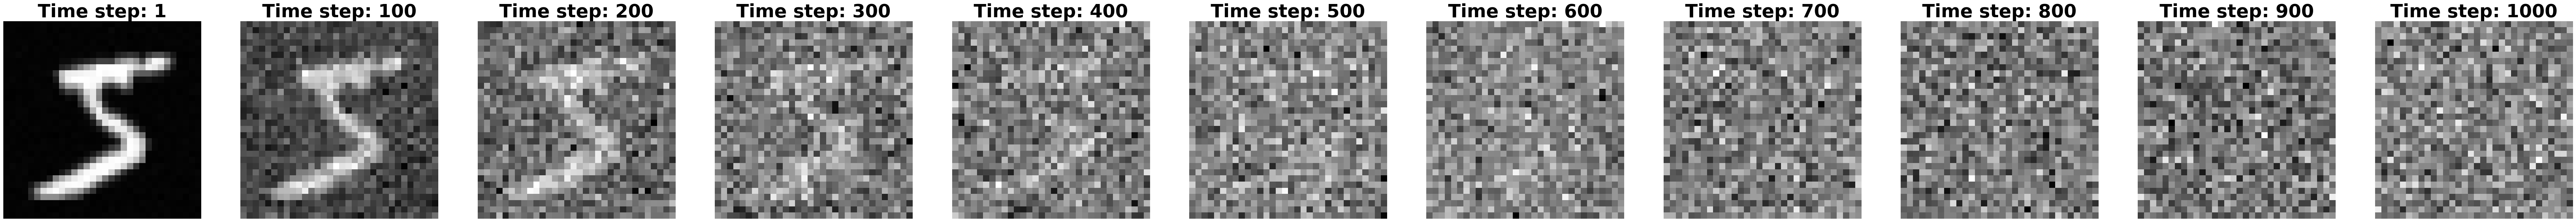

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False)

### Play with forward parameters
Now we check the different effects of the time steps and the starting and ending betas

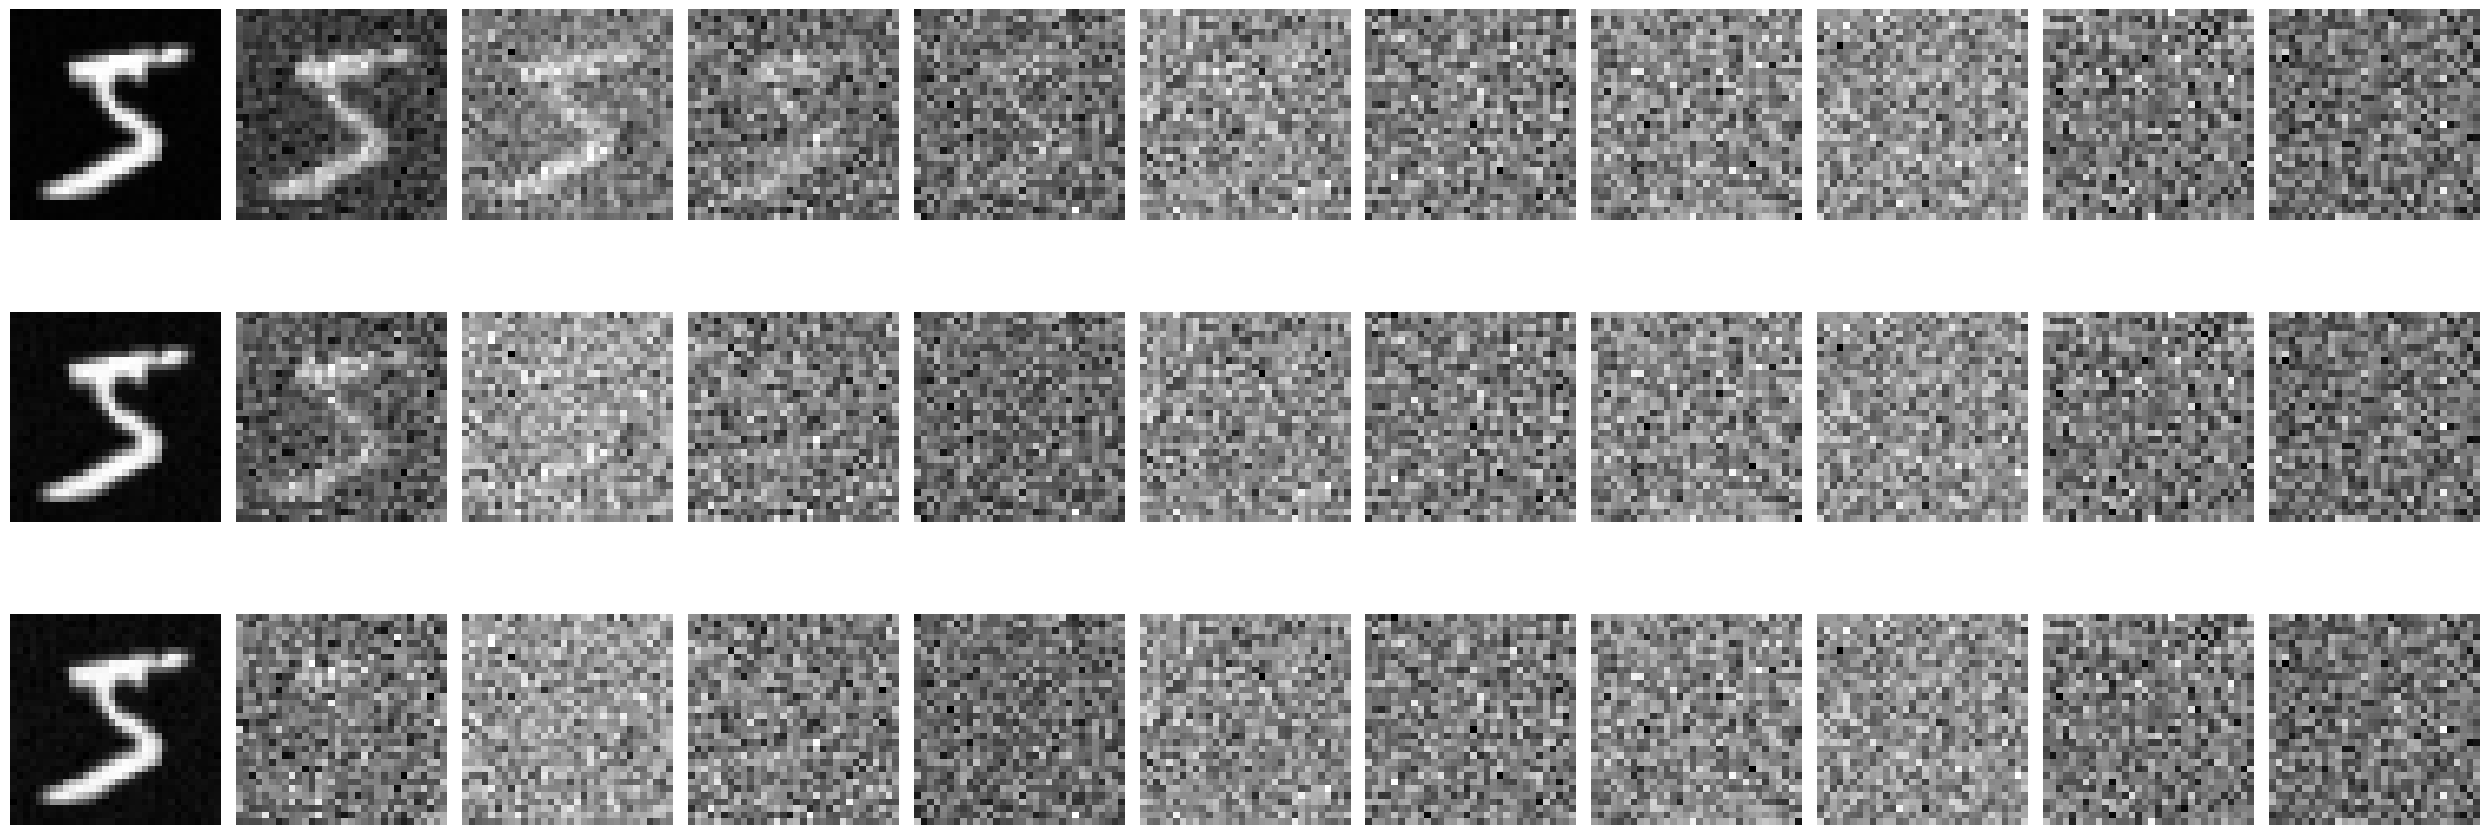

In [14]:
params_list = [
    {'time_steps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02},
    {'time_steps': 500, 'beta_start': 0.0005, 'beta_end': 0.05},
    {'time_steps': 200, 'beta_start': 0.001, 'beta_end': 0.1},
]

# Prepare data
get_img = training_dataset[0][0]
get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()

# Generate noisy images for different parameter settings
fig, axes = plt.subplots(nrows=len(params_list), ncols=11, figsize=(25, 10))

for i, params in enumerate(params_list):
    scheduler = Linear_Variance_Scheduler(time_steps=params['time_steps'],
                                          beta_start=params['beta_start'],
                                          beta_end=params['beta_end'],
                                          device='cpu')
    noisy_img_stack = scheduler.diffusion_process(get_img_stack, get_noise_stack, t_step)
    
    for idx, img in enumerate(noisy_img_stack):
        axes[i, idx].imshow(img.squeeze(), cmap='gray')
        if idx == 0:
            axes[i, idx].set_ylabel(f"Steps: {params['time_steps']}\nBeta: [{params['beta_start']}, {params['beta_end']}]")
        axes[i, idx].axis(False)

plt.tight_layout()
plt.show()

### U-net Architecture:
The architecture of the U-net is composed by:
- Resblock
- SelfAttentionBlock
- Downblock
- Upblock

So we are going to define this building blocks for it in the following code blocks

# ResBlock

In [15]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

# SelfAttentionBlock

In [16]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()
        
        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

# DownBlock

In [17]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# UpBlock

In [18]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()
        
        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# UNet

In [19]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

In [20]:
from torchinfo import summary

summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [64, 1, 32, 32]           --
├─ResBlock: 1-1                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-2                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    └─ResBlock: 3-7                     [64, 64, 16, 16]          74,112
│    │   

# TRAINING

This following function defines the training of the model but receives the scheduler as a parameter to learn specifically for the one selected. 

In [22]:

def train(model, criterion, optimizer, ddpm, num_epochs=10):
    torch.manual_seed(1111)
    torch.cuda.manual_seed(1111)
    torch.cuda.manual_seed_all(1111)
    np.random.seed(1111)

    n_epochs = num_epochs
    training_loss, validation_loss = [], []

    for epoch in range(n_epochs):
        training_losses, validation_losses = [], []
        
        for data, _ in tqdm(training_dataloader):
            model.train()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            trng_batch_loss = criterion(noise, pred_noise)
            optimizer.zero_grad()
            trng_batch_loss.backward()
            optimizer.step()
            training_losses.append(trng_batch_loss.item())
        training_per_epoch_loss = np.array(training_losses).mean()
        
        with torch.inference_mode():
            for data, _ in tqdm(validation_dataloader):
                model.eval()
                data = data.to(device)
                t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
                noise = torch.randn_like(data)
                xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
                pred_noise = torch.tensor(model(xt, t))
                tst_batch_loss = criterion(noise, pred_noise)
                validation_losses.append(tst_batch_loss.item())
            validation_per_epoch_loss = np.array(validation_losses).mean()
            
        training_loss.append(training_per_epoch_loss)
        validation_loss.append(validation_per_epoch_loss)
        
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
        print(f'Validation loss: {validation_per_epoch_loss:.4f}')
    return training_loss, validation_loss


## EVALUATION

In [24]:
# Load the pre-trained MNIST classifier
MNIST_MODULE = "https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1"
mnist_classifier_fn = tfhub.load(MNIST_MODULE)


# Define the classifier function
def classifier_fn(images):
    outputs = mnist_classifier_fn(images=images)
    return outputs  # Outputs is a tensor of logits

# Function to compute activations
def compute_activations(images, num_batches, classifier_fn):
    images_list = tf.split(images, num_or_size_splits=num_batches)
    activations = []

    for batch in images_list:
        outputs = classifier_fn(images=batch)
        activations.append(outputs)

    activations = tf.concat(activations, axis=0)

    return activations

# Compute activations for real MNIST images
def load_mnist():
    ds = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.Resize((28, 28)),  # Ensure images are 28x28
            transforms.ToTensor(),
        ]),
    )

    dl = DataLoader(ds, batch_size=60000, shuffle=False)
    x, _ = next(iter(dl))
    x = x.numpy()  # Convert to NumPy array
    x = np.transpose(x, (0, 2, 3, 1))  # Shape: (N, 28, 28, 1)

    return tf.convert_to_tensor(x, dtype=tf.float32)


The following cell is one of the most importants of this file. In it is defined the training of the models with different time steps and schedulers. We are going to train the three main schedulers for 100, 500, and 1000 time steps; meaning that in the end we train nine different models.
At the end we get the FID scores of all of these models and we compare them in a graphic.

In [ ]:
# DO NOT EXECUTE THIS CELL

model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20
time_steps_list = [100, 500, 1000]
schedulers = {
    'Linear': Linear_Variance_Scheduler,
    'Cosine': Cosine_Variance_Scheduler,    
    'Sigmoid': Sigmoid_Variance_Scheduler,
}

fid_scores = {scheduler_name: [] for scheduler_name in schedulers.keys()}

for scheduler_name, scheduler_class in schedulers.items():
    for time_steps in time_steps_list:
        scheduler = scheduler_class(time_steps=time_steps)
        training_loss, test_loss = train(model, criterion, optimizer, scheduler, num_epochs)

        sampled_imgs, _ = scheduler.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)

        # Resize images from 32x32 to 28x28 using PyTorch
        sampled_imgs_resized = F.interpolate(sampled_imgs, size=(28, 28), mode='bilinear', align_corners=False)

        # Process resized images
        sampled_imgs_np = sampled_imgs_resized.cpu().numpy()  # Convert to NumPy array
        sampled_imgs_np = (sampled_imgs_np * 0.5) + 0.5       # Denormalize to [0, 1]
        sampled_imgs_np = np.clip(sampled_imgs_np, 0, 1)      # Ensure values are within [0, 1]
        sampled_imgs_np = np.transpose(sampled_imgs_np, (0, 2, 3, 1))  # Shape: (N, 28, 28, 1)

        # Convert to TensorFlow tensor
        sampled_imgs_tf = tf.convert_to_tensor(sampled_imgs_np, dtype=tf.float32)

        mnist_images_tf = load_mnist()

        # Compute activations for real MNIST images
        activations_real = compute_activations(mnist_images_tf, num_batches=1, classifier_fn=classifier_fn)

        # Compute activations for generated images
        activations_fake = compute_activations(sampled_imgs_tf, num_batches=1, classifier_fn=classifier_fn)

        # Compute FID
        fid = tfgan.eval.frechet_classifier_distance_from_activations(activations_real, activations_fake)

        fid_scores[scheduler_name].append(fid.numpy())
        print(f'Scheduler: {scheduler_name}, Time steps: {time_steps}, FID score: {fid.numpy()}')

NameError: name 'UNet' is not defined